# Basic Text Classification with Naive Bayes


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [3]:
critics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15561 entries, 1 to 27616
Data columns (total 8 columns):
critic         14792 non-null object
fresh          15561 non-null object
imdb           15561 non-null int64
publication    15561 non-null object
quote          15561 non-null object
review_date    15561 non-null object
rtid           15561 non-null int64
title          15561 non-null object
dtypes: int64(2), object(6)
memory usage: 1.1+ MB


### Explore

In [4]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size
n_movie_n = critics.title.unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))
print("Number of movies:  {:d}".format(n_movie_n))
print("Number of classifier:  {:d}".format(critics.fresh.unique().size))
critics.fresh.unique()

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921
Number of movies:  1921
Number of classifier:  3


array(['fresh', 'rotten', 'none'], dtype=object)

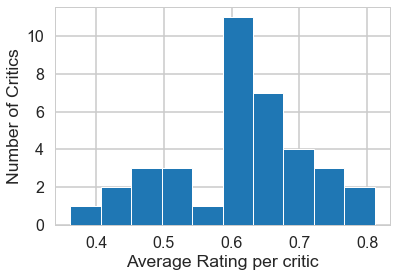

In [5]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh' # maniputate data into 1,0 (fresh, not fresh)
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1) # using means of critic who have more than 100 reviews
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

It seems like the majority of average rating per critic is above 0.6 which can be interpreted that there is more 'fresh' rating than 'rotten' and 'none' rating. However, the critic cannot be too generous about their review,so the average rating per critic drops dramatically after 0.6. From my understanding, there may be a certain 'fresh' rating benchmark of 0.6 for each critic.     

## The Vector Space Model and a Search Engine

### In Code

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [7]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y)
clf = MultinomialNB().fit(xtrain, ytrain)
print  ("score of test data:  {:f}".format(clf.score(xtest, ytest)))
print  ("score of train data:  {:f}".format(clf.score(xtrain, ytrain)))

score of test data:  0.781804
score of train data:  0.920394


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The result looks good with 76 % of accuracy

# CDF

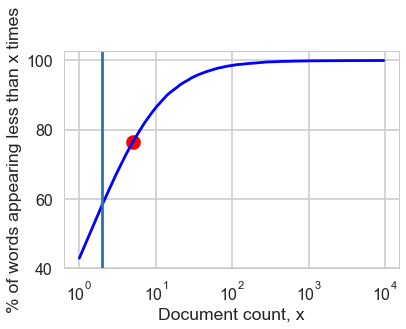

In [9]:
Xmat = X.toarray()
nDocs = Xmat.shape[0]
nWords = Xmat.shape[1]
DocFreq = [0]*nWords
for d in np.arange(nDocs):
    DocFreq = DocFreq + (Xmat[d] != 0)

# evaluate the histogram
values, base = np.histogram(DocFreq, bins=DocFreq.max())
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.semilogx(base[:-1], 100*cumulative/nWords, c='blue')
plt.xlabel("Document count, x")
plt.ylabel("% of words appearing less than x times")
plt.scatter(5, 76.5, c="red", s=200)
plt.axvline(x=2)


Issues I am struggling with: The nature/shape of the curve depends on what value of bins (number of bins) is chosen. I used the maximum value of the document frequency as number of bins here. Based on this, there are about 43% of words that have document count of at least 1. So, going from 0 to 1, there is 43% increase, whereas going from 1 to 2 (vertical line), there is about 15% increase. So, the steepest increase is for the first point. Hence we can set min_df to be 0.0. For the max_df, however, we can set its value to be 1000/(number of documents) becasue there are about 99.9% of the words that have document count of 1000 or less. So, max_df = 1000/15561 = 0.0643.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [13]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [14]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [15]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


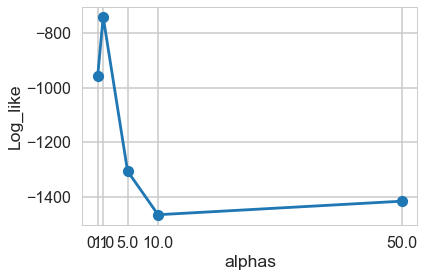

In [16]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 1

#Find the best value for alpha and min_df, and the best classifier
log_like = []
best_alpha = 1
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    clf = MultinomialNB(alpha = alpha)
    log_like.append(cv_score(clf,Xtrainthis,ytrainthis,log_likelihood))
plt.plot(alphas, log_like, '-o')
plt.xlabel('alphas')
plt.ylabel('Log_like')
plt.xticks(alphas)
plt.show()  

In [17]:
print("alpha: {}".format(1))

alpha: 1


# Turning hyperparameter

In [18]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.923110
Accuracy on test data:     0.729251


# Appearently, the turning model does not improve any prediction. 

In [19]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[1881 2375]
 [ 574 6062]]


# What are the strongly predictive features?

In [20]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
         intelligent 0.97
         achievement 0.95
             delight 0.95
              moving 0.94
          remarkable 0.94
              superb 0.94
               witty 0.94
             success 0.94
          represents 0.94
             intense 0.93
Bad words	     P(fresh | word)
            confused 0.13
             muddled 0.13
       unfortunately 0.13
             unfunny 0.11
                dumb 0.11
               tired 0.10
          uninspired 0.09
              stupid 0.08
                lame 0.08
               bland 0.07


The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

## Predict a new review 

In [48]:
clf.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))

array([[0.8427011, 0.1572989]])

the result is not as predict because in the quote there is a lot of positive word 

# Enrichment

In [21]:
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as mt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline

def my_model(data, vectorizer, nkbest, mask, clf, params_for_opt, scoring, cv, selectkbest):
    Xt, yt = make_xy(data, vectorizer)
    if selectkbest:
        Xt_new = SelectKBest(chi2, k=nkbest).fit_transform(Xt, yt)
    else:
        Xt_new = Xt
    x_train=Xt_new[mask]
    y_train=yt[mask]
    x_test=Xt_new[~mask]
    y_test=yt[~mask]

    clf_best = GridSearchCV(estimator = clf, param_grid = params_for_opt, scoring = scoring, cv=cv)
    clf_best.fit(x_train, y_train)
    print("best parameters: ", clf_best.best_params_)
    print("\t")
    y_train_predict = clf_best.predict(x_train)
    y_test_predict = clf_best.predict(x_test)
    training_accuracy = mt.accuracy_score(y_train, y_train_predict)
    test_accuracy = mt.accuracy_score(y_test, y_test_predict)

    training_f1 = mt.f1_score(y_train, y_train_predict)
    test_f1 = mt.f1_score(y_test, y_test_predict)

    fpr, tpr, thresholds = mt.roc_curve(y_train, y_train_predict)
    training_auc = mt.auc(fpr, tpr)

    fpr1, tpr1, thresholds1 = mt.roc_curve(y_test, y_test_predict)
    test_auc = mt.auc(fpr1, tpr1)

    print("Accuracy")
    print("Training: {:2f}".format(training_accuracy))
    print("Test:     {:2f}".format(test_accuracy))
    print("\t")
    print("F1-score")
    print("Training: {:2f}".format(training_f1))
    print("Test:     {:2f}".format(test_f1))
    print("\t")
    print("AUC")
    print("Training: {:2f}".format(training_auc))
    print("Test:     {:2f}".format(test_auc))
    
    return clf_best

In [22]:
best_model = my_model(data=critics, vectorizer=CountVectorizer(ngram_range=(1,3), min_df=0.0, max_df=1000),
                      nkbest = 22000,
                      mask=mask, 
                      clf=MultinomialNB(), 
                      params_for_opt = {'alpha':[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 1]},
                      scoring='roc_auc', 
                      cv=5, selectkbest=False)

best parameters:  {'alpha': 1}
	
Accuracy
Training: 0.998287
Test:     0.736504
	
F1-score
Training: 0.998596
Test:     0.804096
	
AUC
Training: 0.997806
Test:     0.694261


Having n-gram with n>2 tremendously helps in improving the train accuracy but the test accuranct remains same. Lets try to select only some features (rather than all) and see if that improves the accuracy on test data set.

In [23]:
best_model = my_model(data=critics, vectorizer=CountVectorizer(ngram_range=(1,3), min_df=0.0, max_df=1000),
                      nkbest = 22000,
                      mask=mask, 
                      clf=MultinomialNB(), 
                      params_for_opt = {'alpha':[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 1]},
                      scoring='roc_auc', 
                      cv=5, selectkbest=True)

best parameters:  {'alpha': 0.1}
	
Accuracy
Training: 0.973013
Test:     0.860723
	
F1-score
Training: 0.977972
Test:     0.888693
	
AUC
Training: 0.970272
Test:     0.846219




Training accruacy has gone down but the test accuracy incresed from 0.77 to 0.91 by considering 22000 featues.

Can we improve it even more by tokenizing the words to take care of punctuations?


In [24]:
from nltk.tokenize import word_tokenize
from nltk.tokenize.regexp import wordpunct_tokenize
best_model = my_model(data=critics, vectorizer=CountVectorizer(ngram_range=(1,3),
                                                              analyzer = 'word',
                                                 tokenizer=wordpunct_tokenize),
                      nkbest = 22000,
                      mask=mask, 
                      clf=MultinomialNB(), 
                      params_for_opt = {'alpha':[0.00001, 0.0005, 0.0001, 0.0002, 0.001, 0.005]},
                      scoring='roc_auc', 
                      cv=5, selectkbest=True)

best parameters:  {'alpha': 0.005}
	
Accuracy
Training: 0.974941
Test:     0.876148
	
F1-score
Training: 0.979420
Test:     0.899321
	
AUC
Training: 0.974022
Test:     0.867262




Using a tokenizer slightly helps in improving test predictions.

Lets now try to modify the above model by replacing the CountVectorizer with tfidfVectorizer and see if we get any improvements.


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
best_model = my_model(data=critics, vectorizer=TfidfVectorizer(ngram_range=(1,3),
                                                              analyzer = 'word',
                                                 tokenizer=wordpunct_tokenize),
                      nkbest = 22000,
                      mask=mask, 
                      clf=MultinomialNB(), 
                      params_for_opt = {'alpha':[0.00001, 0.0005, 0.0001, 0.0002, 0.001, 0.005]},
                      scoring='roc_auc', 
                      cv=5, selectkbest=True)

best parameters:  {'alpha': 0.005}
	
Accuracy
Training: 0.971300
Test:     0.829324
	
F1-score
Training: 0.976968
Test:     0.874587
	
AUC
Training: 0.963642
Test:     0.788091




Using tfidf weighted vectorizer gives worse predictions. So lets stick to CountVectorizer with wordpunct_tokenize tokenizer.

Let's now use a different classfier, i,e, SVM classifier.


In [27]:
from sklearn.svm import SVC

best_model = my_model(data=critics, vectorizer=CountVectorizer(ngram_range=(1,3),
                                                              analyzer = 'word',
                                                 tokenizer=wordpunct_tokenize),
                      nkbest = 220,
                      mask=mask, 
                      clf=SVC(), 
                      params_for_opt = {'C':[0.1, 1, 10],
                                       'class_weight': ["balanced"],
                                       'gamma': [0.1, 1, 10]},
                      scoring='roc_auc', 
                      cv=5, selectkbest=True)

best parameters:  {'C': 1, 'class_weight': 'balanced', 'gamma': 0.1}
	
Accuracy
Training: 0.750482
Test:     0.664341
	
F1-score
Training: 0.779231
Test:     0.704255
	
AUC
Training: 0.758356
Test:     0.666682




Seems like SVM is also not a good option. So, whatever we tried so far, following is a list of things that give us the best result:

Vectorizer: CountVectorizer()

Classifier: MultinomialNB()

ngram_range: (1,3)

tokenizer: wordpunct_tokenize
